# Multidimensional Probability Heatmap

## Overview

When implementing the MCMC algorithm using a random walk, we need some way of evaluating how likely the current proposal is of being a valid possibility. For our purposes, if we are given an earthquake proposal, we can evaluate its validity by comparing it to the record we have of earthquakes that have already occured. Since earthquakes most frequently occur on fault lines, and since these fault lines typically produce earthquakes that are similar in at least most of the 9 parameters, we can reasonably suppose that if the proposed earthquake is close to a few previously recorded earthquake in those 9 parameters, that it is likely to be a valid possibility of an earthquake as well.

This notebook explores a method of implementing this idea that involves surrounding each known earthquakes with a pdf and adding all of those pdf's together to produce a heatmap. We first walk through the 1 dimensional case, then we extend it to the 2 dimensional case and provide visual demonstrations of how it works. Finally, we discuss extending it to the $n$ dimensional case.

In [64]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
%matplotlib inline
plt.rcParams['figure.figsize'] = [16,8]

In [56]:
# This helper function modified from
# https://stackoverflow.com/questions/1208118/using-numpy-to-build-an-array-of-all-combinations-of-two-arrays
def cartesian(arrays, out=None):
    """
    Generate a cartesian product of input arrays.

    Parameters
    ----------
    arrays : list of array-like
        1-D arrays to form the cartesian product of.
    out : ndarray
        Array to place the cartesian product in.

    Returns
    -------
    out : ndarray
        2-D array of shape (M, len(arrays)) containing cartesian products
        formed of input arrays.

    Examples
    --------
    >>> cartesian(([1, 2, 3], [4, 5], [6, 7]))
    array([[1, 4, 6],
           [1, 4, 7],
           [1, 5, 6],
           [1, 5, 7],
           [2, 4, 6],
           [2, 4, 7],
           [2, 5, 6],
           [2, 5, 7],
           [3, 4, 6],
           [3, 4, 7],
           [3, 5, 6],
           [3, 5, 7]])

    """

    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    m = n / arrays[0].size
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:int(m),1:])
        for j in range(1, arrays[0].size):
            out[j*int(m):(j+1)*int(m),1:] = out[0:int(m),1:]
    return out

## 1 dimension

The one dimensional case is simple and easy to visualize. Assume we are given a value and a dataset and told to determine how likely this new value is to be valid if all the values in the dataset are already known to be valid, and we know that any new valid values will be close to the ones in the dataset. Specifically, let -3, 0, and 5 be the values in the dataset. These data can be used to produce a "heatmap" representing the likelihood of a new point by summing up the pdf's of each point in the dataset. For simplicity we assume each pdf is a normal distribution with standard deviation 1 and a mean equal to the value in question, but in practice this can be any distribution where the values of greatest probability are close to the values in the dataset.

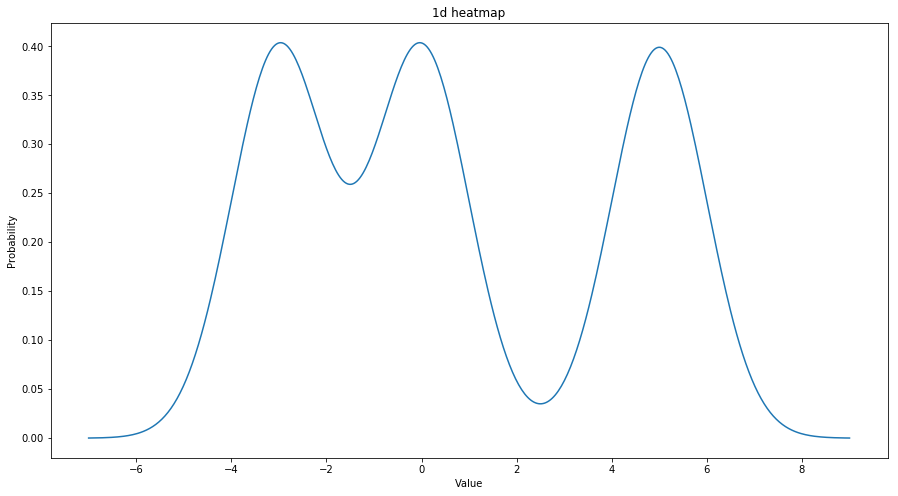

In [57]:
x = np.linspace(-7,9, 500)
f = stats.norm(-3, 1).pdf
g = stats.norm(0,1).pdf
h = stats.norm(5,1).pdf
plt.xlabel("Value")
plt.ylabel("Probability")
plt.title("1d heatmap")
plt.plot(x, f(x) + g(x) + h(x))

As we can see from the above graph, values very close to the actual points from the dataset are the most likely, but the graph also accounts for points that are somewhat close to more than one point in the dataset. In our case, since -3 and 0 were both in the dataset, we would likely expect that values between -3 and 0 would be more probable than values less than -3, since -3 is the lowest value in the dataset. This is clearly seen in the graph, since -1.5 has a probability of over .25, while -4.5 has a probability of under .05, even though both of those values are 1.5 away from -3.

## 2 dimensions

Large earthquakes typically occur along faultlines. As a result, a dataset containing earthquake events will likely have very highly coorelated longitude and latitude values. For the two dimensional heatmap, we will ignore the other seven earthquake parameters and instead only focus on longitude and latitude. We write a function that will generate and return a set of data points representing a fault line.

In [58]:
# Helper function to generate fake fault line since we don't have real data yet.
def generate_fault(bl, tr, cov, N):
    """
    Generate a possible faultline that will represent a set of valid points in the dataset
        by creating a linspace of N elements to function as the mean vectors, then using
        these mean vectors and the covariance matrix, cov, to generate N events that are
        close to the line from bl to tr but not exactly on the line.
    Parameters
    ----------
    bl : a 1d array with two entries (x,y) that represents the bottom left point of the fault.
    tr : a 1d array with two entries (x,y) that represents the top right point of the fault.
    cov : a covariance matrix to be used to generate random points a small distance from the exact fault line.
    N : the number of points to generate.
    
    Returns
    -------
    fault : a 2d array where each row represents an earthquake event.
    """
    x = np.linspace(bl[0], tr[0], N)
    y = np.linspace(bl[1], tr[1], N)
    means = np.vstack((x,y)).T
    fault = []
    for mean in means:
        dist = stats.multivariate_normal(mean, cov)
        earthquake = dist.rvs()
        fault.append(earthquake)
    return np.array(fault)

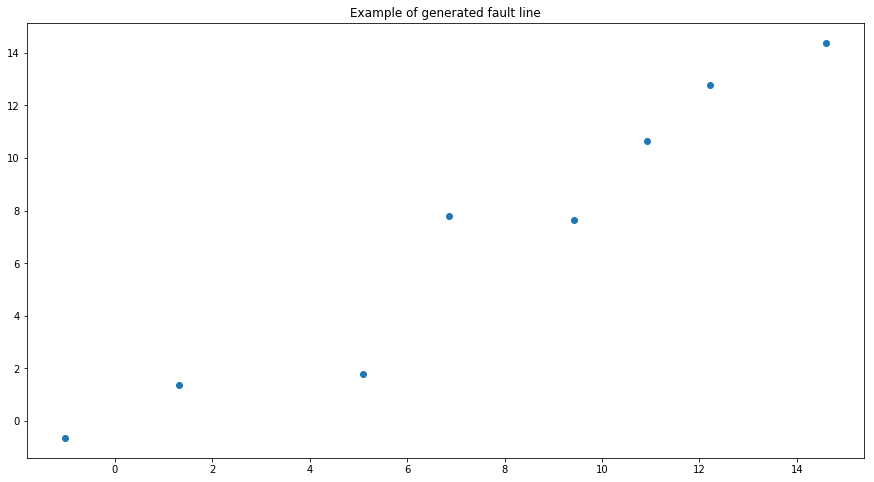

In [59]:
# This is an example of how this function would work if the theoretical fault line was on the line y = x
bl = np.array([0,0])
tr = np.array([15,15])
cov = np.eye(2)
N = 8
fault = generate_fault(bl,tr,cov,N)
plt.scatter(fault[:,0],fault[:,1])
plt.title("Example of generated fault line")

Next we write a function that accepts a dataset representing a fault line and a covariance matrix for how much wiggle room we want to give to the x and y parameters, and plots a heat map representing the probability of a new point being considered valid according to this dataset.

In [66]:
def plot_heatmap(fault, bl, tr, cov=np.eye(2)):
    """
    Plot a heatmap representing the probability of any point in the box being considered valid 
    based on the dataset in fault.
    Parameters
    ----------
    fault : an n X 2 array containing n earthquake events on the fault line.
    bl : a 1d array with two entries (x,y) representing the bottom left point of the generated plot.
    tr : a 1d array with two entries (x,y) representing the top right point of the generated plot.
    cov : the covariance matrix to use on the events to calculate the heatmap.
    """
    N = 100
    x = np.linspace(bl[0],tr[0],N)
    y = np.linspace(bl[1],tr[1],N)
    X,Y = np.meshgrid(x,y)
    probability = np.zeros_like(X)
    for event in fault:
        for i in range(N):
            for j in range(N):
                probability[i][j] += stats.multivariate_normal(event,cov).pdf(np.array([X[i][j], Y[i][j]]))
    plt.pcolormesh(X,Y, probability, cmap="viridis")
    cbar = plt.colorbar()
    cbar.set_label("Probability")
    plt.title("2d heatmap")

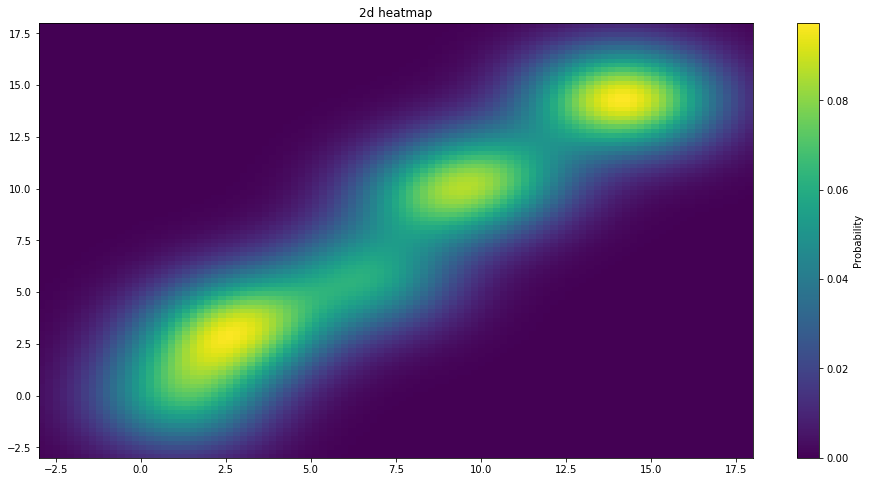

In [67]:
bl2 = np.array([-3,-3])
tr2 = np.array([18,18])
cov = 3*np.eye(2)
plot_heatmap(fault,bl2,tr2,cov)

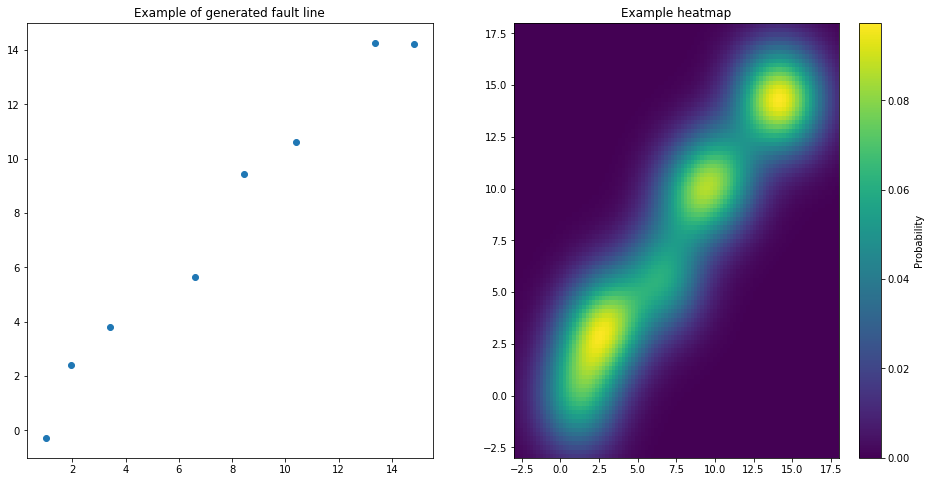

In [65]:
# Here we see the two side by side:
bl = np.array([0,0])
tr = np.array([15,15])
cov = np.eye(2)
N = 8
fault = generate_fault(bl,tr,cov,N)
plt.subplot(121)
plt.scatter(fault[:,0],fault[:,1])
plt.title("Example of generated fault line")

bl2 = np.array([-3,-3])
tr2 = np.array([18,18])
cov = 3*np.eye(2)
plt.subplot(122)
plot_heatmap(fault,bl2,tr2,cov)

Of course, while the heatmap is instructive, it isn't quite what we're looking for. We want to be able to calculate the probability of one specific point, not generate the pdf of the whole grid. Luckily, this is much quicker to do. We write a function that accepts a fault line and the covariance matrix to use in calculation, as well as a point somewhat close to the fault line. The function returns the probability of that point being valid based on the same procedure we discussed above.

In [68]:
def calc_probability(point, fault, cov):
    """
    Calculate the probability that point is valid based on its proximity to the fault using
        cov as the covariance matrix.
    Parameters
    ----------
    point : a 1d array with two entries (x,y) representing the new point.
    fault : an n X 2 array containing n earthquake events on the fault line.
    cov : the covariance matrix to use on the events to calculate the probability.
    """
    probability = 0.
    for event in fault:
        probability += stats.multivariate_normal(event,cov).pdf(point)
    return probability

We show some examples using the previous fault line.

In [70]:
# Example 1: point - (2.5,2.5); expectation - high probability
point1 = np.array([2.5, 2.5])
# Example 2: point - (7.5,7.5); expectation - medium probability
point2 = np.array([7.5, 7.5])
# Example 3: point - (10.0,0.0); expectation - low probability
point3 = np.array([10.0, 0.])

cov = 3*np.eye(2)
prob1 = calc_probability(point1,fault,cov)
prob2 = calc_probability(point2,fault,cov)
prob3 = calc_probability(point3,fault,cov)
print(prob1)
print(prob2)
print(prob3)

0.0961016933769
0.0535176614634
4.28189229236e-05


We can also show how this would work by putting these newly generated plots on the scatter plot of the fault line and using their probabilities as their sizes.

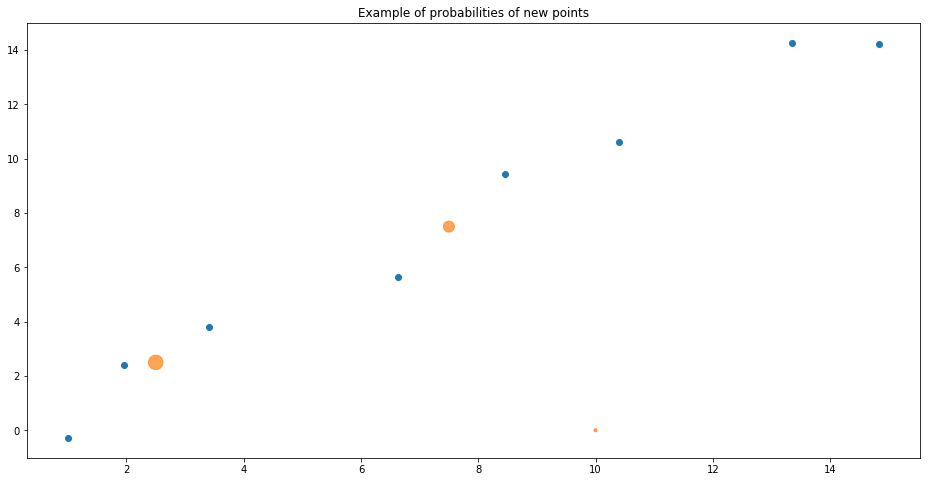

In [76]:
x = np.array([2.5,7.5,10.])
y = np.array([2.5,7.5,0.])
z = np.array([prob1,prob2,prob3])
z = (z-min(z))/(max(z) - min(z)) # normalize probs
z = (z*200.) + 10. # scale large enough to show up in the graph
plt.scatter(fault[:,0],fault[:,1])
plt.title("Example of probabilities of new points")

plt.scatter(x,y,s=z,alpha=.7)

As we can see here, the size of the new points corresponds very well with the location of the fault line, with points closer to the line being larger.

## n dimensions

Generating the fault line, heat maps, and calculating the probability of new points would all extend very naturally and easily from 2 dimensions to $n$ dimensions. However, with each new dimension the computation time would increase greatly. This makes generating a heatmap prohibitively expensive, but a 9 dimensional heatmap doesn't reveal much information anyways. Calculating the probability, however, is possible in 9 dimensions, and in fact the calc_probability function would work for this without any modification except for to the dimensions of the input parameters.